In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import kagglehub

In [5]:
dataset_path = kagglehub.dataset_download("ashishsaxena2209/animal-image-datasetdog-cat-and-panda")


In [6]:
dataset_dir = os.path.join(dataset_path, 'animals')
categories = ['cats', 'dogs', 'panda']
image_paths = []
img_size = 32
train_data = []
max_images = 100


for label, category in enumerate(categories):
    path = os.path.join(dataset_dir, category)
    for img_name in os.listdir(path):
        image_paths.append((os.path.join(path, img_name), label))


np.random.shuffle(image_paths)
selected_images = image_paths[:max_images]


for img_path, label in tqdm(selected_images, desc="Loading 100 total images"):
    try:
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (img_size, img_size))
        train_data.append([resized.flatten(), label])
    except:
        continue


Loading 100 total images: 100%|██████████| 100/100 [00:01<00:00, 99.25it/s]


In [14]:
np.random.shuffle(train_data)
X = np.array([sample[0] for sample in train_data])
y = np.array([sample[1] for sample in train_data])


def euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan(a, b):
    return np.sum(np.abs(a - b))

In [12]:
def knn(train_X, train_y, test_X, k, distance='l2'):
    predictions = []
    for test_point in test_X:
        distances = []
        for i, train_point in enumerate(train_X):
            if distance == 'l2':
                d = euclidean(test_point, train_point)
            else:
                d = manhattan(test_point, train_point)
            distances.append((d, train_y[i]))
        distances.sort(key=lambda x: x[0])
        k_nearest = [label for _, label in distances[:k]]
        most_common = Counter(k_nearest).most_common(1)[0][0]
        predictions.append(most_common)
    return np.array(predictions)


In [13]:
def evaluate_knn(X, y, ks, distance='l2'):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    all_fold_accuracies = {k: [] for k in ks}

    for k in ks:
        fold_accuracies = []
        for train_idx, val_idx in kf.split(X):
            train_X, val_X = X[train_idx], X[val_idx]
            train_y, val_y = y[train_idx], y[val_idx]
            preds = knn(train_X, train_y, val_X, k, distance)
            acc = accuracy_score(val_y, preds)
            fold_accuracies.append(acc)
        all_fold_accuracies[k] = fold_accuracies
        avg_accuracy = np.mean(fold_accuracies)
        print(f"K = {k}, Distance = {distance.upper()}, Accuracy = {avg_accuracy:.4f}")
    return all_fold_accuracies


Evaluating with Euclidean (L2) distance:
K = 1, Distance = L2, Accuracy = 0.3200
K = 3, Distance = L2, Accuracy = 0.3500
K = 5, Distance = L2, Accuracy = 0.3700
K = 7, Distance = L2, Accuracy = 0.3600
K = 9, Distance = L2, Accuracy = 0.3600
K = 11, Distance = L2, Accuracy = 0.3700
K = 13, Distance = L2, Accuracy = 0.3800
K = 15, Distance = L2, Accuracy = 0.3500
K = 17, Distance = L2, Accuracy = 0.3500
K = 19, Distance = L2, Accuracy = 0.3800

Evaluating with Manhattan (L1) distance:
K = 1, Distance = L1, Accuracy = 0.3700
K = 3, Distance = L1, Accuracy = 0.4100
K = 5, Distance = L1, Accuracy = 0.3900
K = 7, Distance = L1, Accuracy = 0.3500
K = 9, Distance = L1, Accuracy = 0.3600
K = 11, Distance = L1, Accuracy = 0.3300
K = 13, Distance = L1, Accuracy = 0.3600
K = 15, Distance = L1, Accuracy = 0.3300
K = 17, Distance = L1, Accuracy = 0.3300
K = 19, Distance = L1, Accuracy = 0.3600


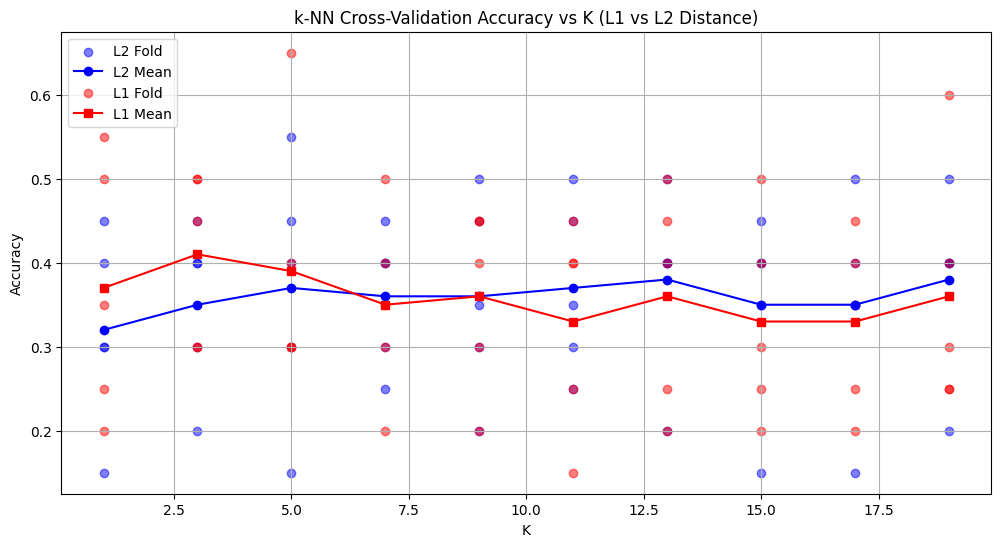

In [28]:
ks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]


print("\nEvaluating with Euclidean (L2) distance:")
l2_results = evaluate_knn(X, y, ks, distance='l2')


print("\nEvaluating with Manhattan (L1) distance:")
l1_results = evaluate_knn(X, y, ks, distance='l1')


def plot_cross_val_results(ks, l2_results, l1_results):
    plt.figure(figsize=(12, 6))


    for i, k in enumerate(ks):
        plt.scatter([k] * 5, l2_results[k], color='blue', alpha=0.5, label='L2 Fold' if i == 0 else "")
    plt.plot(ks, [np.mean(l2_results[k]) for k in ks], marker='o', color='blue', label='L2 Mean')


    for i, k in enumerate(ks):
        plt.scatter([k] * 5, l1_results[k], color='red', alpha=0.5, label='L1 Fold' if i == 0 else "")
    plt.plot(ks, [np.mean(l1_results[k]) for k in ks], marker='s', color='red', label='L1 Mean')

    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.title("k-NN Cross-Validation Accuracy vs K (L1 vs L2 Distance)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cross_val_results(ks, l2_results, l1_results)


The graph showing the performance of KNN with Manhattan (L1) vs. Euclidean (L2) distance across different values of k (number of neighbors) using 5-fold cross-validation. From the graph Euclidean (L2) showing better  accuracy (around 38%) and more stable across different k values.On the other hand Manhattan (L1) peaked at k=3 (around 41%) but dropped sharply for larger k.So, for this dataset L2 is working better. But the limitions of this image classification approach is low accuracy, which ranges between 33% to 41%, which indicates that raw pixel features do not capture enough meaningful information about the images to distinguish between different classes effectively. Raw pixels treat each pixel as equally important, ignoring patterns like edges, textures, or shapes, which are often crucial for recognizing objects in images.

Another  limitation is the high sensitivity to the value of k in k-Nearest Neighbors (k-NN) when using the L1 distance metric. As the value of k increases, the model’s performance  dropping significantly.It doesn't generalize well across different configurations. To improve performance, better features such as HOG, LBP, or CNN-based embeddings can be used instead of raw pixels. Adding data augmentation (like rotating, flipping, or shifting images) can help increase the variety in training data. Trying more advanced models like SVM, Random Forest, or a basic CNN can also lead to higher accuracy.


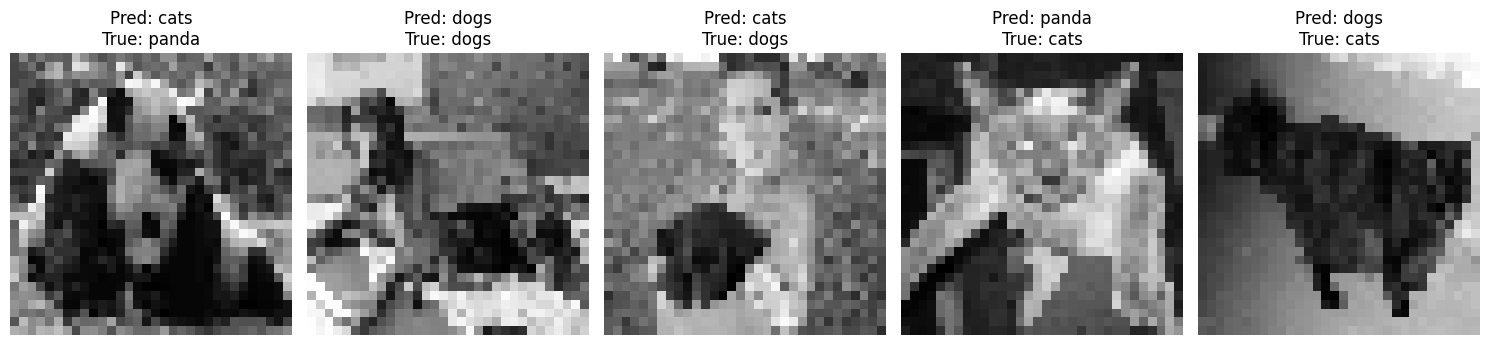

In [27]:
def display_top_predictions(knn_func, X_val, y_val, categories, num_images=5):
    indices = np.random.choice(len(X_val), num_images, replace=False)
    val_samples = X_val[indices]
    val_labels = y_val[indices]

    predictions = knn_func(X_train_fold, y_train_fold, val_samples, k=5, distance='l2')

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(val_samples[i].reshape(32, 32), cmap='gray')
        plt.title(f"Pred: {categories[predictions[i]]}\nTrue: {categories[val_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in kf.split(X):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    break

display_top_predictions(knn, X_val_fold, y_val_fold, categories)